# Import libraries

In [1]:
from datasets import load_dataset
from transformers import (AutoModelForSeq2SeqLM, AutoTokenizer, 
                          Seq2SeqTrainingArguments, Seq2SeqTrainer)
import random
import torch

/opt/conda/envs/cs109b/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-08 18:12:41.050455: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 18:12:41.103605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 18:12:42.027573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Te

# Load Data

In [2]:
train_dataset = load_dataset("scientific_papers", "pubmed", split="train")

Found cached dataset scientific_papers (/home/u_51520750/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [3]:
val_dataset = load_dataset("scientific_papers", "pubmed", split="validation")

Found cached dataset scientific_papers (/home/u_51520750/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [4]:
test_dataset = load_dataset("scientific_papers", "pubmed", split="test")

Found cached dataset scientific_papers (/home/u_51520750/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


# Rationale for Including Second Model

Alongside the OSCAR model, we developed a new model that employs a GPT-2 encoder and huggingface's seq2seq architecture. This model was constructed as a comparison point and an alternative method to OSCAR.

# Preprocess Data

## Load GPT-2 Tokenizer from Hugging Face

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [6]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

## Set Parameters

In [7]:
max_input_length = 8192
max_output_length = 512
batch_size = 2

## Pre-processing Function

The function below ("process_data_to_model_inputs") takes a batch of data as its inpus and tokenizes the "article" and "abstract" fields using the GPT-2 tokenizer.

In [8]:
def process_data_to_model_inputs(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=max_input_length)
    outputs = tokenizer(batch["abstract"], padding="max_length", truncation=True, max_length=max_output_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["global_attention_mask"] = len(batch["input_ids"]) * [[0 for _ in range(len(batch["input_ids"][0]))]]
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids
    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

    return batch

## Downsample

 We downsample our data to make model training much quicker due to CPU limitations.

In [9]:
num_shards = 1000
raw_sub_train_dataset = train_dataset.shard(num_shards=num_shards, index=random.randint(0, num_shards - 1))
raw_sub_val_dataset = val_dataset.shard(num_shards=num_shards, index=random.randint(0, num_shards - 1))

## Tokenize and Convert to Torch

In [10]:
sub_train_dataset = raw_sub_train_dataset.map(process_data_to_model_inputs, batched=True, batch_size=batch_size, remove_columns=["article", "abstract", "section_names"])
sub_val_dataset = raw_sub_val_dataset.map(process_data_to_model_inputs, batched=True, batch_size=batch_size, remove_columns=["article", "abstract", "section_names"])

In [11]:
sub_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "global_attention_mask", "labels"])
sub_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "global_attention_mask", "labels"])

# Model 1

Below, we load a pre-trained version of the LED (Linformer-based Encoder-Decoder) model for seq-to-seq language modeling using the AutoModelForSeq2SeqLM class from huggingface.

In [12]:
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

## Train / Fine Tune Model

In [51]:
training_args = Seq2SeqTrainingArguments(
    output_dir="allenai/led-base-16384_finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="allenai/led-base-16384_logs",
    num_train_epochs=3,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=led,
    args=training_args,
    train_dataset=sub_train_dataset,
    eval_dataset=sub_val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,5.870500,5.495304
2,4.777000,5.290465
3,4.363900,5.199156


TrainOutput(global_step=180, training_loss=5.003811815049914, metrics={'train_runtime': 41165.0255, 'train_samples_per_second': 0.009, 'train_steps_per_second': 0.004, 'total_flos': 1944147481067520.0, 'train_loss': 5.003811815049914, 'epoch': 3.0})

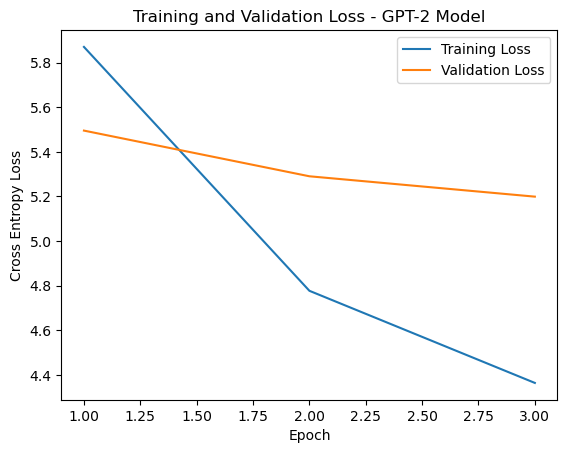

In [109]:
import matplotlib.pyplot as plt
epochs = [1, 2, 3]
training_loss = [5.870500, 4.777000, 4.363900]
validation_loss = [5.495304, 5.290465, 5.199156]

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss - GPT-2 Model')
plt.legend()
plt.show()

# Save Model

In [54]:
#led.save_pretrained('model1_gpt2')


In [100]:
led.save_pretrained('final_gpt2')
tokenizer.save_pretrained('final_gpt2')

('final_gpt2/tokenizer_config.json',
 'final_gpt2/special_tokens_map.json',
 'final_gpt2/vocab.json',
 'final_gpt2/merges.txt',
 'final_gpt2/added_tokens.json',
 'final_gpt2/tokenizer.json')

# Load Model

In [14]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


In [105]:
model_path = "final_gpt2"
led = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [106]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

## Test Model 1

In [20]:
led.config.num_beams = 1
led.config.max_length = 512
led.config.min_length = 100
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

In [114]:
# choose random article to test
#random_index = random.randint(0, len(sub_val_dataset) - 1)
# hard-code random index for practical purposes
random_index = 2
sample = sub_val_dataset[random_index]

device = torch.device("cpu")
led.to(device)

input_ids = sample["input_ids"].unsqueeze(0).to(device)
attention_mask = sample["attention_mask"].unsqueeze(0).to(device)
global_attention_mask = sample["global_attention_mask"].unsqueeze(0).to(device)


In [115]:
# generate summary
with torch.no_grad():
    summary_ids = led.generate(input_ids=input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)


/opt/conda/envs/cs109b/lib/python3.11/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [116]:
generated_summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
print("Generated Summary:")
print(generated_summary)

Generated Summary:
# background hiccup is an involuntary, paroxysmal, inspiratory movement of the chest wall, associated with contraction of the diaphragm and accessory respiratory muscles, with synchronous glottis closure the cause of such hiccups may not always be organic. 
 we present a series of four cases in the pediatric age group, who presented with hiccression of psychogenic origin to our center and were treated accordingly.  
 the present cases of the four children and adolescents from india.  Arsenal the present a 0 of psych a hiccMy in children and decided from ind htt. � the present recognition of the cases and ranged from 74 to 84.  det the present in children the cases.  the present there of the there and ranged vent 74 to and were.  per the present fit of the fit and ranged with h promups in children to results. in - fact psychogenic hicc frequent are considered a subtype of intractable hicc30. m the developmental aspects and sympathetic understanding of the associated p

In [121]:
actual_summary = raw_sub_val_dataset[random_index]["abstract"]
print("Actual Summary:")


Actual Summary:


In [122]:
print(actual_summary)

 hiccups can be due to organic diseases or psychogenic causes . 
 psychogenic hiccup in children is an understudied area . 
 we report a series of four cases presenting with psychogenic hiccups to the psychiatry outpatient clinic of a tertiary care hospital in north india . 
 the cases were aged 11 to 13 years ; three of them were males and one female . 
 three of the patients belonged to a rural background and all of them were from hindu nuclear families . 
 the duration of hiccups for which treatment was sought ranged from three to fourteen months . the most common gains seen in two of the patients were , lesser scolding from the parents and getting eatables of their choice . 
 the patients were managed by counseling and psychoeducation about the problem and cutting down the secondary gain . 
 techniques of suggestion and double bind were tried . 
 two of the patients had improved on the day detailed assessments were done , and all of the patients had improved on follow up . 
 psycho

# Overall Assessment

# Assesment of GPT-2 Model: Low-to-Medium Performance
**Strengths of Generated Summary**: 
- Captures some of the key content of the actual abstract. 
- Clearly attempts to *summarize* information (e.g., starts with a "background" statement) 

**Weaknesses of Generated Summary**:
- Does not read like an actual professional abstract
- Can not coherently tie together relevant information
- Incorporates nonsensical sentences
- Summary is way too long

On balance, the generated summaries of the CHAT-gpt article are OK, and provide some sense of the overall takeways text, but fail to cogently and coherently summarize the PubMed articles.